# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing More Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction


Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, we will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. We will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. We will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

Before looking at the bike sharing data, we should start by asking questions we might want to understand about the bike share data. Consider, for example, if we were working for Motivate. What kinds of information would we want to know about in order to make smarter business decisions? If we were a user of the bike-share service, what factors might influence how would we want to use the service? <br>
<i> Following questions can be tackled: <br> 1. Stations with high demand of bikes? <br>           2. How long most people ride the bike for? <br>         3.  Which age-group uses bikes the most? <br>           4. What bikes are preferred the most? </i> 

<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

The data has already been collected in the `/data/` folder of the project files. While the original data for 2016 is spread among multiple files for each city, the files in the `/data/` folder collect all of the trip data for the year into one file per city. Some data wrangling of inconsistencies in timestamp format within each city has already been performed. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. 
<br><br>
There is still a lot of data for us to investigate, so it's a good idea to start off by looking at one entry from each of the cities we're going to analyze.

In [1]:
## import all necessary packages and functions.
import csv 
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in a nicer way than the base print function.

In [2]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city)) # print city name for reference
    
    with open(filename, 'r') as f_in:
        csvreader = csv.DictReader(f_in) #opening a DictReader Object
        
    
        first_trip = next(csvreader) #reading line from DictReader object see https://docs.python.org/3/library/csv.html#reader-objects
        
        pprint(first_trip) #print first trip
        pass
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

When we set up a `DictReader` object, the first row of the data file is normally interpreted as column names. Every other row in the data file will use those column names as keys, as a dictionary is generated for each row.

This will be useful since we can refer to quantities by an easily-understandable label instead of just a numeric index. For example, if we have a trip stored in the variable `row`, then we would rather get the trip duration from `row['duration']` instead of `row[0]`.

<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.


In [3]:
def duration_in_mins(datum, city):

#     Takes as input a dictionary containing info about a single trip (datum) and
#     its origin city (city) and returns the trip duration in units of minutes.
    
#     Washington is in terms of milliseconds while Chicago and NYC
#     are in terms of seconds. 

    
    if city == "NYC" or city == "Chicago":
        duration = (float(datum['tripduration']))/60.0 #seconds to minutes
    else:
        duration = (float(datum['Duration (ms)']))/60000.0 #milliseconds to minutes
    return duration


# Some tests to check that code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# we printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [4]:
def time_of_trip(datum, city):

#     Takes as input a dictionary containing info about a single trip (datum) and
#     its origin city (city) and returns the month, hour, and day of the week in
#     which the trip was made.

#     NYC includes seconds, while Washington and Chicago do not.

    days = {0: 'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5: 'Saturday', 6: 'Sunday'}
    if city == "NYC":
        dated = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M:%S')
        month = dated.date().month
        hour = dated.time().hour
        weekday = days[dated.weekday()] #weekday() return int for corresponding day
    elif city == "Chicago":
        dated = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M')
        month = dated.date().month
        hour = dated.time().hour
        weekday = days[dated.weekday()]
    else:
        dated = datetime.strptime(datum['Start date'], '%m/%d/%Y %H:%M')
        month = dated.date().month
        hour = dated.time().hour
        weekday = days[dated.weekday()]

    return(month, hour, weekday)



# Some tests to check that code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# we printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]


In [5]:
def type_of_user(datum, city):

#     Takes as input a dictionary containing info about a single trip (datum) and
#     its origin city (city) and returns the type of system user that made the
#     trip.
    
#     Washington has different category names compared to Chicago
#     and NYC.

    if city == "NYC" or city == "Chicago":
        user_type = datum['usertype']
    else:
        if datum['Member Type'] == 'Registered':
            user_type = 'Subscriber'
        else:
            user_type = 'Customer'
    
    
    return user_type


# Some tests to check that code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# we printed the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

**Using** the helper functions we wrote above, creating a condensed data file for each city consisting only of the data fields indicated above.

In [6]:
def condense_data(in_file, out_file, city):

#     This function takes full data from the specified input file
#     and writes the condensed data to a specified output file. The city
#     argument determines how the input file will be parsed.
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # setting up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        #setting up csv DictReader object
        
        trip_reader = csv.DictReader(f_in)

        # collect data from file and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed data
            new_point = {}

            # Using the helper functions to get the cleaned data from the original data dictionaries.                              ##
                      
            new_point['duration'] = duration_in_mins(row, city) #returns duration
            new_point['month'], new_point['hour'], new_point['day_of_week'] = time_of_trip(row, city) #returns month, hour, weekday
            new_point['user_type'] = type_of_user(row, city) #returns user_type
            
            

            ## Writing the processed information to the output file. ##
            ## see https://docs.python.org/3/library/csv.html#writer-objects ##
            trip_writer.writerow(new_point)
            

In [7]:
# Checking our work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

In this section we will write some code to compute descriptive statistics from the data and create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers.

**Let's tackle the following**: Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?
#### We have:
<i> The city of <b> NYC </b> has highest number of trips. <br> <b>NYC</b> also has highest proportion of trips made by subscribers! <br> <b>Chicago</b> has highest proportion of trips made by short-term customers. </i>

In [8]:
def number_of_trips(filename):
    
#     This function reads in a file with trip data and reports the number of
#     trips made by subscribers, customers, and total overall.
    
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total)

In [9]:
## Writing code to run the above functions and runing 
## the function on the cleaned data files, created from Question 3.

data_file = ['./data/Chicago-2016-Summary.csv','./data/NYC-2016-Summary.csv','./data/Washington-2016-Summary.csv']
city = ["Chicago","NYC","Washington"]
for i in range(0,3):
    print(city[i], ":")
    n_sub, n_cust, n_total = number_of_trips(data_file[i])
    print("    Trips made by \n\t Subscribers= {}, \n\t Customers= {}, \n\t Total trips= {} ".format(n_sub, n_cust, n_total))
    print("    Proportion of trips made by subscribers: ", ((n_sub/float(n_total))*100), "%")
    print("    Proportion of trips made by short-term customers: ", ((n_cust/float(n_total))*100), "%\n")


Chicago :
    Trips made by 
	 Subscribers= 54982, 
	 Customers= 17149, 
	 Total trips= 72131 
    Proportion of trips made by subscribers:  76.22520136973007 %
    Proportion of trips made by short-term customers:  23.774798630269924 %

NYC :
    Trips made by 
	 Subscribers= 245896, 
	 Customers= 30902, 
	 Total trips= 276798 
    Proportion of trips made by subscribers:  88.83590199351151 %
    Proportion of trips made by short-term customers:  11.164098006488485 %

Washington :
    Trips made by 
	 Subscribers= 51753, 
	 Customers= 14573, 
	 Total trips= 66326 
    Proportion of trips made by subscribers:  78.0282242257938 %
    Proportion of trips made by short-term customers:  21.971775774206193 %



**Question**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

**Answer**: <i>Chicago : <br>
    Average trip length =  16.564 minutes. <br>
    Proportion of rides longer than 30 minutes:  8.33 % <br>
NYC : <br>
    Average trip length =  15.813 minutes. <br>
    Proportion of rides longer than 30 minutes:  7.3 % <br>
Washington : <br>
    Average trip length =  18.933 minutes. <br>
    Proportion of rides longer than 30 minutes:  10.84 % </i>

In [10]:
def trip_length(filename):
    with open(filename, 'r') as f_in:
        ## setting up csv reader object
        reader = csv.DictReader(f_in)
        ## initialising variables
        total_duration = 0
        n_count = 0
        n_30 = 0
        for row in reader:
            total_duration += float(row['duration'])
            if float(row['duration']) > 30.0:
                n_30 += 1
            n_count += 1
        _average = total_duration/n_count #average trip length of each city
        p_n_30 = round((n_30/n_count)*100, 2) #proportion of rides longer than 30 minutes rounded off to 2 places
        
        return(_average, p_n_30)

In [11]:
for i in range(0,3):
    print(city[i], ":")
    _average, p_30 = trip_length(data_file[i])
    print("    Average trip length = ", round(_average, 3), " minutes.") #rounding off to 3 decimal places. 
    print("    Proportion of rides longer than 30 minutes: ", p_30, "%")

Chicago :
    Average trip length =  16.564  minutes.
    Proportion of rides longer than 30 minutes:  8.33 %
NYC :
    Average trip length =  15.813  minutes.
    Proportion of rides longer than 30 minutes:  7.3 %
Washington :
    Average trip length =  18.933  minutes.
    Proportion of rides longer than 30 minutes:  10.84 %


**Question**: Dig deeper into the question of trip duration based on ridership. Choose one city. Within that city, which type of user takes longer rides on average: Subscribers or Customers?

**Answer**: <i> City Chosen- <b>Washington</b> : <br>
    Average trip length of subscriber =  12.528  minutes. <br>
    Average trip length of customer =  41.678  minutes. <br>
Customers take longer rides on average. </i>

In [12]:
def trip_length_s(filename):
    with open(filename, 'r') as f_in:
        # setting up csv reader object
        reader = csv.DictReader(f_in)
        #initialising variables
        c_duration, s_duration, c_count, s_count = 0,0,0,0 
        for row in reader:
            if row['user_type']== 'Subscriber':
                s_duration += float(row['duration'])
                s_count +=1
            else:
                c_duration += float(row['duration'])
                c_count +=1
        s_average = s_duration/s_count #average trip length of subscriber in the city
        c_average = c_duration/c_count #average trip length of customer in the city
        
        return(s_average, c_average)

In [13]:
print("City Chosen-", city[2], ":")
s_average, c_average = trip_length_s(data_file[2])
print("    Average trip length of subscriber = ", round(s_average, 3), " minutes.") #rounding off to 3 decimal places. 
print("    Average trip length of customer = ", round(c_average, 3), " minutes.") #rounding off to 3 decimal places.
if s_average-c_average > 0:
    print("Subscribers take longer rides on average.\n")
else:
    print("Customers take longer rides on average.\n")

City Chosen- Washington :
    Average trip length of subscriber =  12.528  minutes.
    Average trip length of customer =  41.678  minutes.
Customers take longer rides on average.



<a id='visualizations'></a>
### Visualizations

The last set of values that we computed have pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. 

In [14]:
# load library
import matplotlib.pyplot as plt

# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook. If you want to know more, see:
# http://ipython.readthedocs.io/en/stable/interactive/magics.html
%matplotlib inline 

## Use this and additional cells to collect all of the trip times as a list ##
## and then use pyplot functions to generate a histogram of trip times.     ##
def trip_times(filename):
    
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        
        time_list = []
        for row in reader:
            time_list.append(round(float(row['duration']), 3)) #list of trip times of one city
        return time_list


City Chosen - Washington :


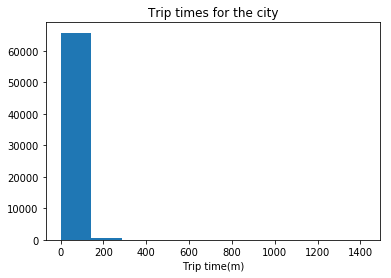

In [15]:
# n_list = []
# for i in range(0,3):
#     n_list.extend(trip_times(data_file[i])) #uncomment for extending list to all cities
print("City Chosen -", city[2], ":")
n_list = trip_times(data_file[2]) #comment if extending
plt.hist(n_list)
plt.title("Trip times for the city")
plt.xlabel("Trip time(m)")
plt.show()
   

**Observation**: <i> For <b> Subscribers </b> peak is at 17500. While, for <b> Customers </b> peak is at 2000.The shape can be described as <b> skewed right. </b> </i>

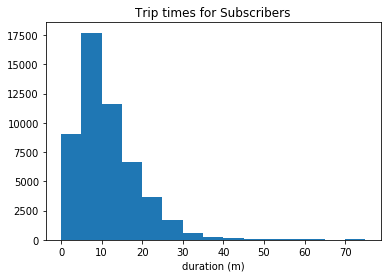

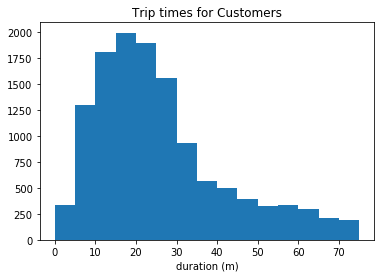

In [16]:
## Use this and additional cells to answer Question 5. ##
n_list1 = []
n_list2 = []
with open(data_file[2], 'r') as f_in:
        reader = csv.DictReader(f_in)
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_list1.append(round(float(row['duration']), 3))
            else:
                n_list2.append(round(float(row['duration']), 3))
                
plt.hist(n_list1, bins = range(0,80,5), range=(0,75) )
plt.title('Trip times for Subscribers')
plt.xlabel('duration (m)')
plt.show()
plt.hist(n_list2,bins = range(0,80,5), range=(0,75) )
plt.title('Trip times for Customers')
plt.xlabel('duration (m)')
plt.show()

<a id='eda_continued'></a>
## Performing More Analysis
**Let us tackle how ridership varies by month** <br> <i> Ridership differences by month follow a trend: <br> Subscribers of <b>NYC</b> rode mostly in the month of December (12) implying that the number of subscribers have increased steadily. <br> As number of customers peaked in August and September. Their number gradually decreased towards december implying customers were turned into subscribers but number of customers didn't rise. <br> The ratio of Subscriber trips to Customer trips varies greatly with each month as ploted in graph below:
</i>

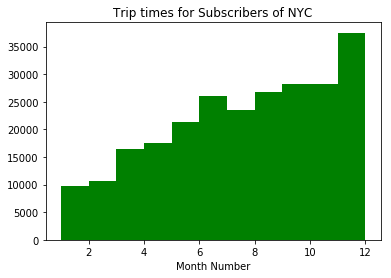

In [17]:
## Generic function to calculate months and put them in list ##
# def n_month(filename):
#     with open(filename, 'r') as f_in:
#         reader = csv.DictReader(f_in)
        
#         month_list = []
#         for row in reader:
#             month_list.append(int(row['month'])) #list of months of one city
#         return month_list
m_list_s =[]
m_list_c =[]

with open(data_file[1], 'r') as f_in:
    reader = csv.DictReader(f_in)
    for row in reader:
        if row['user_type'] == 'Subscriber':
            m_list_s.append(int(row['month']))
        else:
            m_list_c.append(int(row['month']))
ratio_list =[]
for i in range(0,12):
    ratio_list.append((m_list_s.count(i+1))/(m_list_c.count(i+1)))

    
##Trip times for Subscribers of NYC
plt.hist(m_list_s, bins = range(1,13,1), range=(1,12), color='green')
plt.title('Trip times for Subscribers of NYC')
plt.xlabel('Month Number')
plt.show()

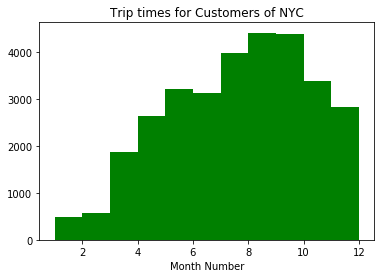

In [18]:
##Trip times for Customers of NYC
plt.hist(m_list_c,bins = range(1,13,1), range=(1,12), color='green' )
plt.title('Trip times for Customers of NYC')
plt.xlabel('Month Number')
plt.show()
 

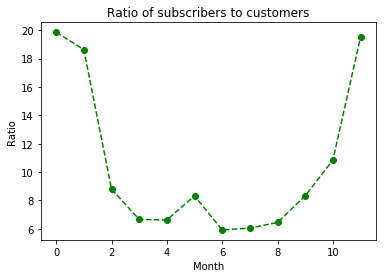

In [19]:
## Ratio of subscribers to customers
#print(ratio_list)
plt.plot(ratio_list,color='green', marker='o', linestyle='dashed')
plt.title('Ratio of subscribers to customers')
plt.xlabel('Month')
plt.ylabel('Ratio')
#plt.tick_params(axis='x', length = 12, width = 1)
plt.show()

<a id='conclusions'></a>
## Conclusions

This is only a sampling of the data analysis process: from generating questions, wrangling the data, and to exploring the data. Normally, at this point in the data analysis process, we might want to draw conclusions about the data by performing a statistical test or fitting the data to a model for making predictions. There are also a lot of potential analyses that could be performed on the data which are not possible with only the data provided. For example, detailed location data has not been investigated. Where are the most commonly used docks? What are the most common routes? As another example, weather has potential to have a large impact on daily ridership. How much is ridership impacted when there is rain or snow? Are subscribers or customers affected more by changes in weather?

**Putting the bike share data aside, think of a topic or field of interest where you would like to be able to apply the techniques of data science. What would you like to be able to learn from your chosen subject?**


### _Mentored by OSAhub@MSIT_